In [1]:
import io
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import operator
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
ratings = pd.read_csv('/content/drive/MyDrive/rating.csv')

In [19]:
# uploaded = files.upload()
anime = pd.read_csv('/content/drive/MyDrive/anime.csv')

In [5]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
ratings = ratings[ratings.rating != -1]
ratings.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


6337241
69600
12294


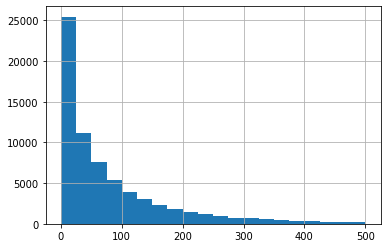

In [7]:
# number of ratings
print(len(ratings))

# number of users
print(len(ratings['user_id'].unique()))

# number of unique animes (in anime list, not ratings)
print(len(anime['anime_id'].unique()))

# avg number of anime rated per user
ratings_per_user = ratings.groupby('user_id')['rating'].count()
statistics.mean(ratings_per_user.tolist())

# distribution of ratings per user
# (we may want to exclude users without many data points)
%matplotlib inline
ratings_per_user.hist(bins=20, range=(0,500))

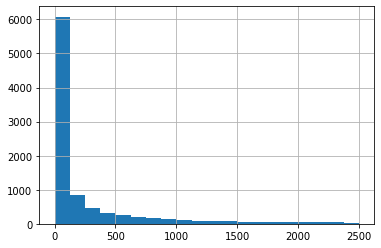

In [8]:
# avg number of ratings given per anime
ratings_per_anime = ratings.groupby('anime_id')['rating'].count()
statistics.mean(ratings_per_anime.tolist())

# distribution of ratings per anime
%matplotlib inline
ratings_per_anime.hist(bins=20, range=(0,2500))

In [9]:
# counts of ratings per anime as a df
ratings_per_anime_df = pd.DataFrame(ratings_per_anime)
# remove if < 1000 ratings
filtered_ratings_per_anime_df = ratings_per_anime_df[ratings_per_anime_df.rating >= 1000]
# build a list of anime_ids to keep
popular_anime = filtered_ratings_per_anime_df.index.tolist()

In [10]:
# counts ratings per user as a df
ratings_per_user_df = pd.DataFrame(ratings_per_user)
# remove if < 500
filtered_ratings_per_user_df = ratings_per_user_df[ratings_per_user_df.rating >= 500]
# build a list of user_ids to keep
prolific_users = filtered_ratings_per_user_df.index.tolist()

In [11]:
filtered_ratings = ratings[ratings.anime_id.isin(popular_anime)]
filtered_ratings = ratings[ratings.user_id.isin(prolific_users)]
len(filtered_ratings)

1005314

In [12]:
rating_matrix = filtered_ratings.pivot_table(index='user_id', columns='anime_id', values='rating')
# replace NaN values with 0
rating_matrix = rating_matrix.fillna(0)
# display the top few rows
rating_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
226,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
294,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392,7.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446,9.0,8.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
rating_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 226 to 73502
Columns: 9591 entries, 1 to 34475
dtypes: float64(9591)
memory usage: 99.9 MB


In [14]:
def similar_users(user_id, matrix, k=3):
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    # create list of indices of these users
    indices = other_users.index.tolist()
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indices, similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_similarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_similarities]
    
    return users

In [15]:
def recommend_item(user_index, similar_user_indices, matrix, items=10):
    
    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    # calc avg ratings across the 3 similar users
    similar_users = similar_users.mean(axis=0)
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
  
    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    # remove any rows without a 0 value. Anime not watched yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # generate a list of animes the user has not seen
    animes_unseen = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only anime the current user has not seen
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(animes_unseen)]
    # order the dataframe
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    # grab the top n anime   
    top_n_anime = similar_users_df_ordered.head(items)
    top_n_anime_indices = top_n_anime.index.tolist()
    # lookup these anime in the other dataframe to find names
    anime_information = anime[anime['anime_id'].isin(top_n_anime_indices)]
    
    return anime_information #items

In [16]:
similar_user_indices = similar_users(271, rating_matrix)
print(similar_user_indices)
recommend_item(271, similar_user_indices, rating_matrix)

[1103, 13652, 20314]


,anime_id,name,genre,type,episodes,rating,members
10,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749
36,11741,Fate/Zero 2nd Season,"Action, Fantasy, Supernatural, Thriller",TV,12,8.73,340973
94,10087,Fate/Zero,"Action, Fantasy, Supernatural",TV,13,8.51,453630
96,9756,Mahou Shoujo Madoka★Magica,"Drama, Magic, Psychological, Thriller",TV,12,8.51,462974
180,18195,Little Busters!: Refrain,"Comedy, Drama, Romance, School, Slice of Life,...",TV,13,8.36,71820
223,2167,Clannad,"Comedy, Drama, Romance, School, Slice of Life,...",TV,23,8.30,566690
262,23289,Gekkan Shoujo Nozaki-kun,"Comedy, Romance, School",TV,12,8.24,292622
335,12189,Hyouka,"Mystery, School, Slice of Life",TV,22,8.17,372246
370,4059,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen","Drama, Romance, School, Slice of Life",Special,1,8.14,160423
504,6351,"Clannad: After Story - Mou Hitotsu no Sekai, K...","Drama, Romance, School",Special,1,8.02,138364


In [17]:
similar_user_indices = similar_users(226, rating_matrix)
print(similar_user_indices)
recommend_item(226, similar_user_indices, rating_matrix)

[30773, 39021, 45603]


,anime_id,name,genre,type,episodes,rating,members
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
16,23273,Shigatsu wa Kimi no Uso,"Drama, Music, Romance, School, Shounen",TV,22,8.92,416397
39,12365,Bakuman. 3rd Season,"Comedy, Drama, Romance, Shounen",TV,25,8.71,133620
67,22535,Kiseijuu: Sei no Kakuritsu,"Action, Drama, Horror, Psychological, Sci-Fi, ...",TV,24,8.59,425457
87,10030,Bakuman. 2nd Season,"Comedy, Drama, Romance, Shounen",TV,25,8.53,151561
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817
150,57,Beck,"Comedy, Drama, Music, Shounen, Slice of Life",TV,26,8.40,148328
184,7674,Bakuman.,"Comedy, Romance, Shounen",TV,25,8.35,246899
206,813,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",TV,291,8.32,375662
374,17265,Log Horizon,"Action, Adventure, Fantasy, Game, Magic, Shounen",TV,25,8.14,387100
